## Load data

# R_10, R_20, 1% flux compared to center galaxy selected R_10

In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data, header = fits.getdata('DESIJ1537+1443_F140W_drz_sci.fits', header=True)

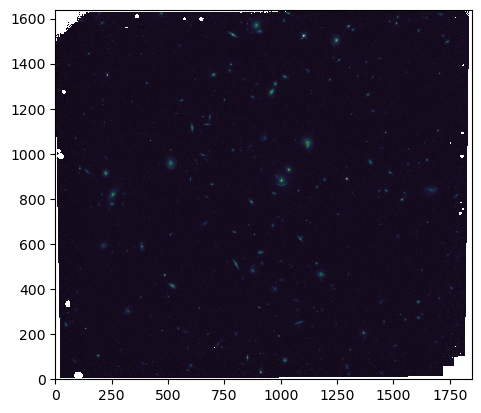

In [3]:
plt.imshow(np.log10(data), origin='lower',
           cmap='cubehelix', interpolation='nearest')

## Background estimation

In [4]:
from astropy.stats import SigmaClip
from photutils.background import Background2D, MedianBackground
sigma_clip = SigmaClip(sigma=3.0)
bkg_estimator = MedianBackground()
bkg = Background2D(data, (50, 50), filter_size=(3, 3),
                   sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

C:\Users\HTCM\AppData\Local\Temp\ipykernel_10044\4133483403.py:1: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(data - bkg.background), origin='lower',


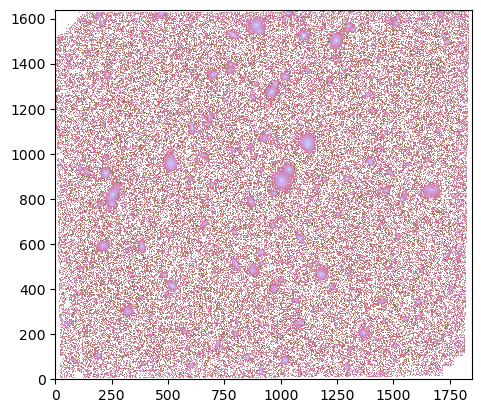

In [8]:
plt.imshow(np.log10(data - bkg.background), origin='lower',
           cmap='cubehelix', interpolation='nearest')

## Aperture photometry

In [9]:
np.median(bkg.background), np.median(bkg.background_rms)

(0.25551219532307734, 0.012066100362562024)

In [10]:
bkg_subtracted_data = data - bkg.background

In [23]:
threshold = 3 * bkg.background_rms

In [24]:
from photutils.segmentation import detect_sources
segment_map = detect_sources(bkg_subtracted_data, threshold, npixels=10)

In [25]:
from photutils.segmentation import deblend_sources
segm_deblend = deblend_sources(bkg_subtracted_data, segment_map,
                               npixels=10, nlevels=32, contrast=0.001,
                               progress_bar=False)


In [26]:
from photutils.segmentation import SourceFinder
finder = SourceFinder(npixels=10, progress_bar=False)
segment_map = finder(bkg_subtracted_data, threshold)

print(segment_map)

<photutils.segmentation.core.SegmentationImage>
shape: (1640, 1849)
nlabels: 802
labels: [  1   2   3   4   5 ... 798 799 800 801 802]


In [27]:
from photutils.segmentation import SourceCatalog
cat = SourceCatalog(bkg_subtracted_data, segm_deblend)
print(cat)

<photutils.segmentation.catalog.SourceCatalog>
Length: 802
labels: [  1   2   3   4   5 ... 798 799 800 801 802]


C:\Users\HTCM\AppData\Local\Temp\ipykernel_10044\1098857721.py:8: RuntimeWarning: invalid value encountered in log10
  ax1.imshow(np.log10(bkg_subtracted_data), origin='lower', cmap='cubehelix',)


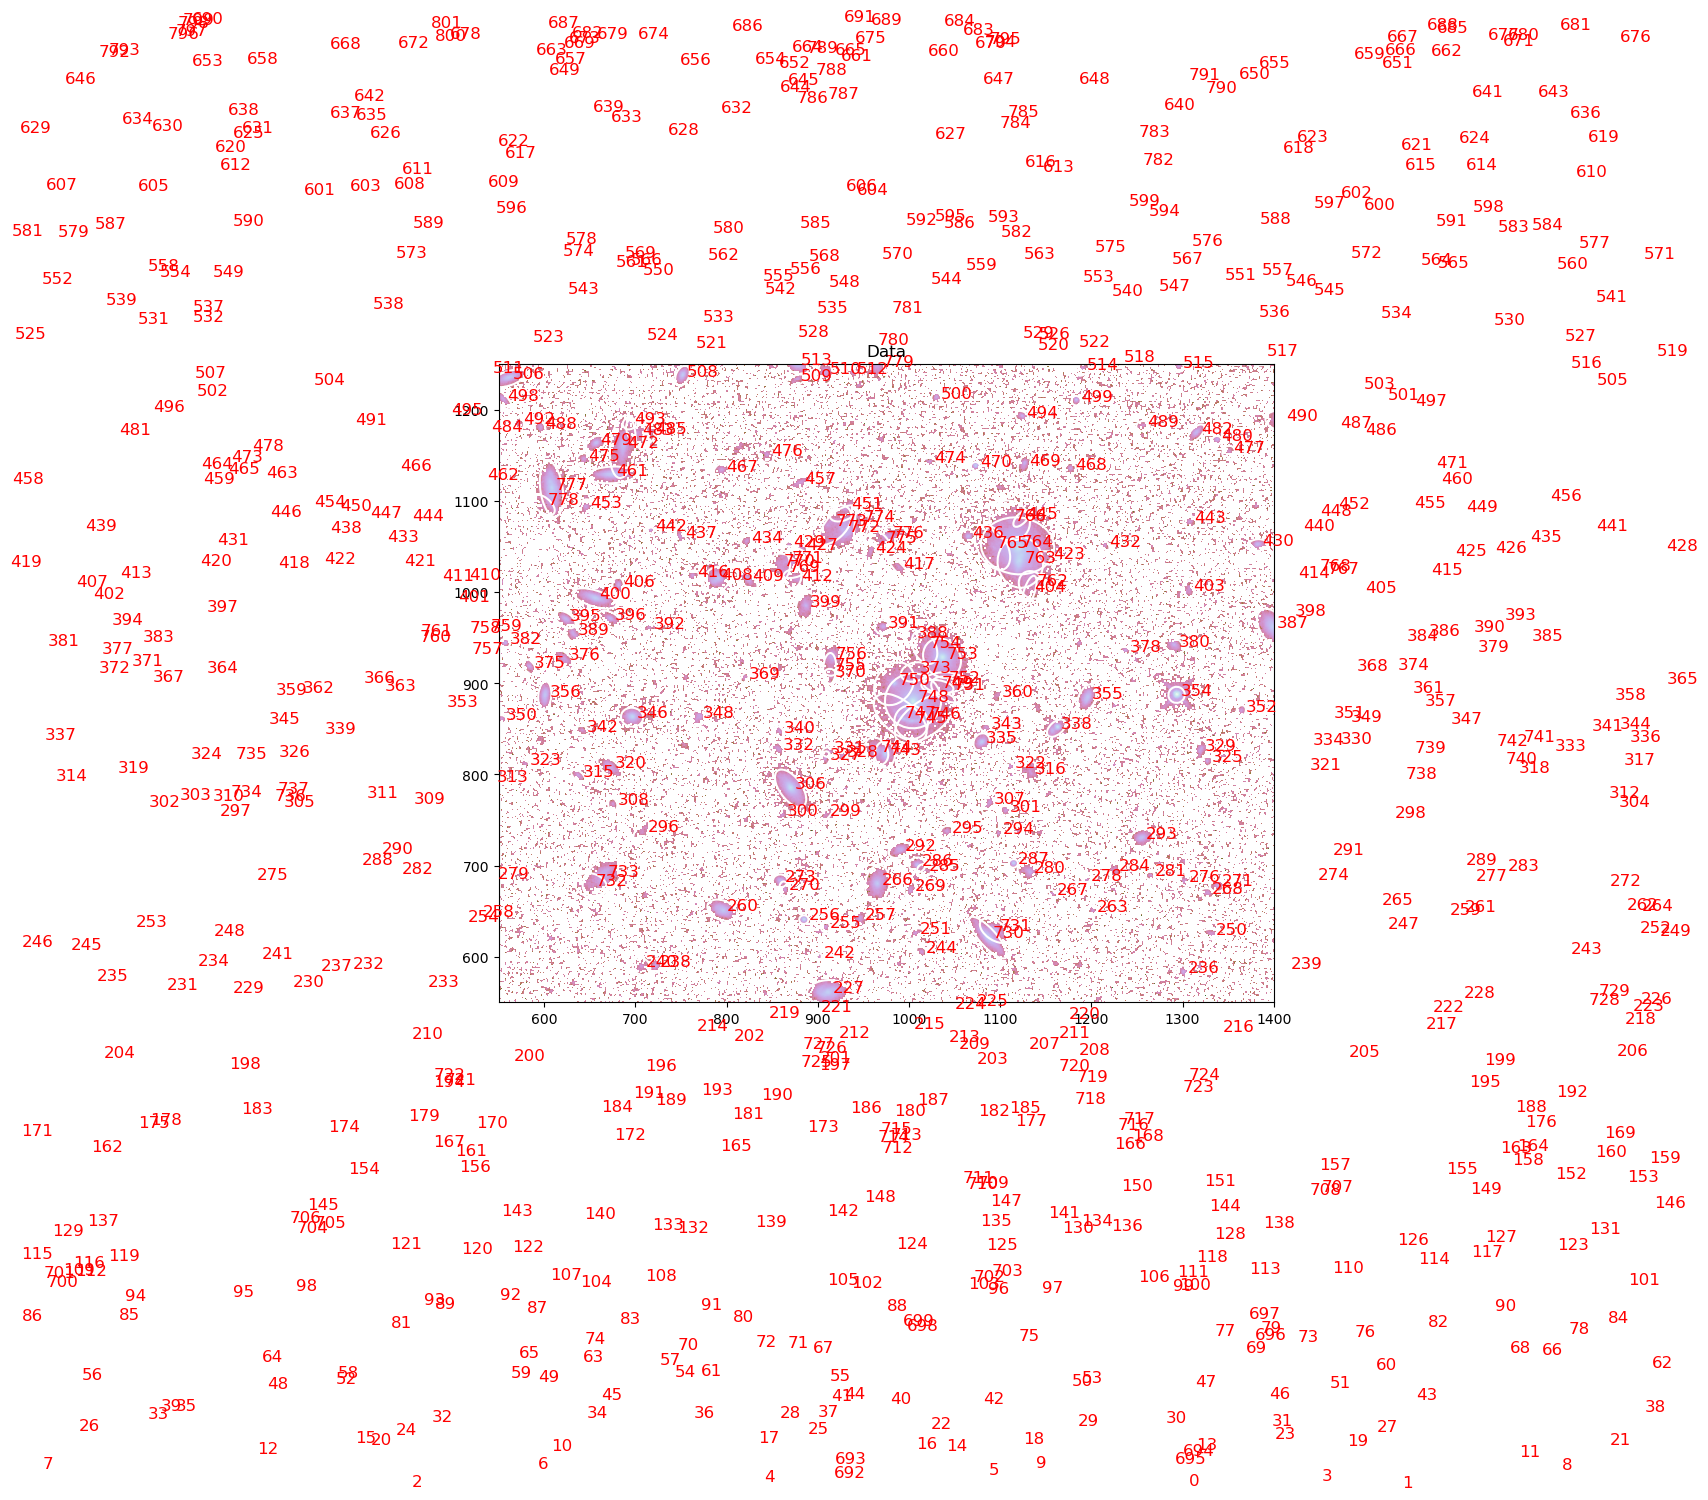

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm

norm = simple_norm(bkg_subtracted_data, 'sqrt')

fig, ax1 = plt.subplots(1, 1, figsize=(10, 12.5))
ax1.imshow(np.log10(bkg_subtracted_data), origin='lower', cmap='cubehelix',)
ax1.set_title('Data')

# ax2.imshow(segm_deblend, origin='lower', cmap=segm_deblend.cmap,
#            interpolation='nearest')
# ax2.set_title('Segmentation Image')
cat.plot_kron_apertures(ax=ax1, color='white', lw=1.5);

for i in range(len(cat)):
    ax1.text(cat.xcentroid[i]+5, cat.ycentroid[i],
             f'{i}', c='r', fontsize=12
             #transform=ax1.transAxes
             )
#cat.plot_kron_apertures(ax=ax2, color='white', lw=1.5);

ax1.set_xlim(750-200, 1000+400)
ax1.set_ylim(550, 1250)

# hide all text outside of the axes
ax1.set_clip_on(True)
ax1.set_clip_box(ax1.bbox)


In [29]:
tbl = cat.to_table()
tbl['xcentroid'].info.format = '.2f'  # optional format
tbl['ycentroid'].info.format = '.2f'
tbl['kron_flux'].info.format = '.2f'

In [30]:
# close galaxies
x0 = tbl['xcentroid'].value[132]
y0 = tbl['ycentroid'].value[132]

close_galaxies = []
dist_galaxies = []
for i in range(len(tbl)):
    if i == 134:
        continue
    x = tbl['xcentroid'].value[i]
    y = tbl['ycentroid'].value[i]
    if np.sqrt((x-x0)**2 + (y-y0)**2) < 20/0.08:
        print(i)
        close_galaxies.append(i)
        dist_galaxies.append(np.sqrt((x-x0)**2 + (y-y0)**2))
len(close_galaxies)

17
28
34
36
45
49
54
55
57
59
61
63
65
67
70
71
72
74
80
83
87
88
91
92
102
104
105
107
108
120
122
124
132
133
139
140
142
143
148
156
165
170
172
173
181
184
186
189
190
191
193
196
197
201
202
214
712
714
715
725
726
727


62

In [31]:
from astropy.wcs import WCS

def distance_arcsec(x):
    wcs = WCS(header)

    pixel_distance = x

    # Get the pixel scale in degrees per pixel
    pix_scale_deg = abs(wcs.wcs.cd[0, 0])

    # Convert pixel scale to arcseconds
    pix_scale_arcsec = pix_scale_deg * 3600

    dist_arcsec = pixel_distance * pix_scale_arcsec

    return dist_arcsec

In [32]:
import pandas as pd

df = pd.DataFrame({'Distance(pixels)': dist_galaxies})

# Set the existing index as the new index for the DataFrame
df.set_index(pd.Index(close_galaxies), inplace=True)

df['Distance(arcsec)'] = distance_arcsec(df['Distance(pixels)'])

# Sort the DataFrame based on 'Distance'
df_sorted = df.sort_values(by='Distance(pixels)')

# Exclude the lensing system members
df_sys_removed = df_sorted.iloc[6:]

#first 10 galaxies
df_10 = df_sys_removed.iloc[:10]

print(df_10)

     Distance(pixels)  Distance(arcsec)
140        103.162945          8.253036
80         115.195942          9.215675
83         117.743124          9.419450
104        121.238467          9.699077
172        123.229649          9.858372
70         127.749895         10.219992
181        139.303027         11.144242
189        142.645394         11.411632
57         145.864614         11.669169
107        147.856196         11.828496


In [33]:
R_10 = df_10.iloc[9, df.columns.get_loc('Distance(arcsec)')]

Sigma_10=10/(np.pi * R_10*2)
print(Sigma_10)

0.1345521422784823


In [34]:
from photutils.aperture import CircularAnnulus, CircularAperture

galaxies_10 = df_10.index.tolist()

print(galaxies_10)

positions = [(cat.xcentroid[i], cat.ycentroid[i]) for i in galaxies_10]

aperture = CircularAperture(positions, r=20.0)

[140, 80, 83, 104, 172, 70, 181, 189, 57, 107]


(600.0, 1250.0)

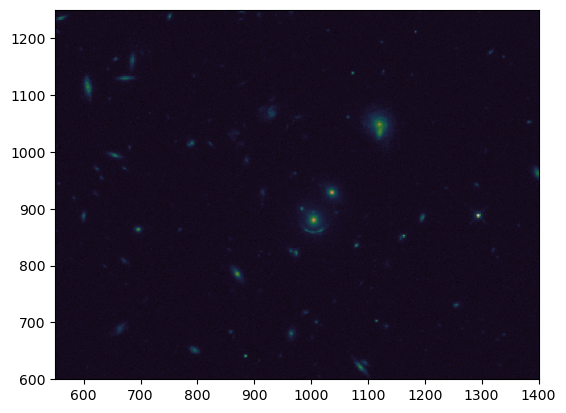

In [37]:
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
from photutils.aperture import CircularAnnulus, CircularAperture
from photutils.datasets import make_100gaussians_image


plt.imshow(np.log10(data), interpolation='nearest', origin='lower', cmap='cubehelix')

ap_patches = aperture.plot(color='white', lw=2,
                           label='Photometry aperture')

handles = (ap_patches[0])

# plt.legend(loc=(0.17, 0.05), facecolor='#458989', labelcolor='white',
#            handles=handles, prop={'weight': 'bold', 'size': 11})

plt.xlim(750-200, 1000+400)
plt.ylim(600, 1250)